Using device: cuda
Training width=2 ...
Training width=4 ...
Training width=8 ...
Training width=16 ...
Training width=32 ...
Training width=64 ...
Training width=128 ...
Training width=256 ...
Training width=512 ...
Training width=1024 ...


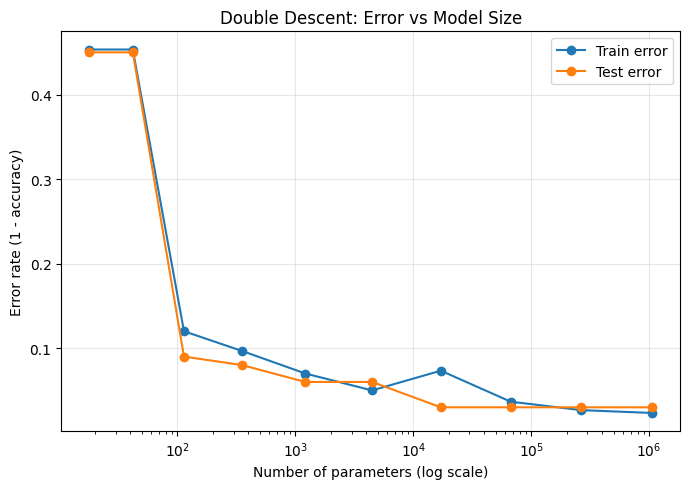

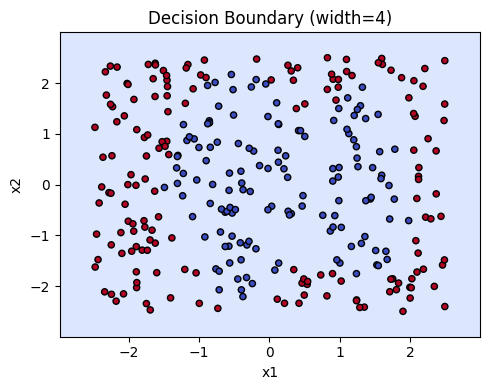

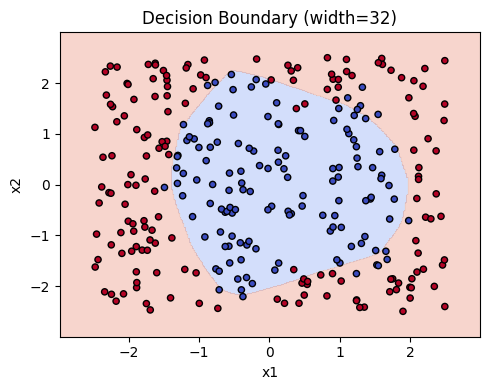

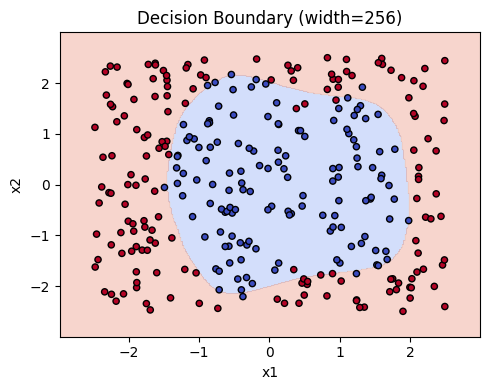

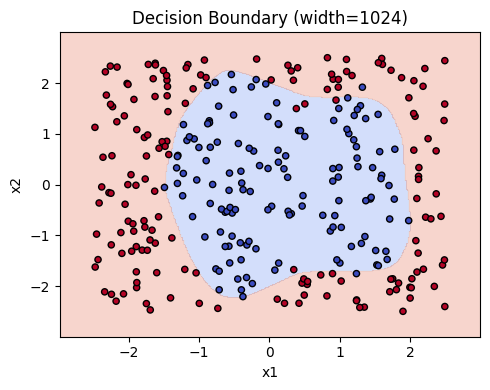


Saved images:
- double_descent_error_curve.png
- decision_boundary_width_4.png
- decision_boundary_width_32.png
- decision_boundary_width_256.png
- decision_boundary_width_1024.png


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# ----------------------------
# Setup
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# For reproducibility
torch.manual_seed(0)
np.random.seed(0)

# ----------------------------
# Synthetic 2D classification dataset
# ----------------------------
def make_dataset(n_samples=300):
    # Points roughly on a noisy circle with a sinusoidal twist
    X = torch.empty(n_samples, 2).uniform_(-2.5, 2.5)
    r = torch.sqrt(X[:, 0]**2 + X[:, 1]**2)
    y = (r + 0.5 * torch.sin(3 * X[:, 0]) > 2.0).long()
    return X, y

X, y = make_dataset(400)
perm = torch.randperm(X.size(0))
X, y = X[perm], y[perm]

n_train = 300
X_train, y_train = X[:n_train], y[:n_train]
X_test,  y_test  = X[n_train:], y[n_train:]

# Keep CPU copies for plotting
X_train_cpu, y_train_cpu = X_train.clone(), y_train.clone()
X_test_cpu,  y_test_cpu  = X_test.clone(),  y_test.clone()

# ----------------------------
# MLP model
# ----------------------------
class MLP(nn.Module):
    def __init__(self, input_dim=2, width=50, depth=2, num_classes=2):
        super().__init__()
        layers = []
        in_dim = input_dim
        for _ in range(depth):
            layers.append(nn.Linear(in_dim, width))
            layers.append(nn.ReLU())
            in_dim = width
        layers.append(nn.Linear(in_dim, num_classes))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# ----------------------------
# Training function
# ----------------------------
def train_model(width, epochs=200, lr=1e-2):
    model = MLP(width=width).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    X_tr = X_train.to(device)
    y_tr = y_train.to(device)
    X_te = X_test.to(device)
    y_te = y_test.to(device)

    train_acc_hist = []
    test_acc_hist = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        logits = model(X_tr)
        loss = criterion(logits, y_tr)
        loss.backward()
        optimizer.step()

        # Record accuracy
        model.eval()
        with torch.no_grad():
            pred_train = logits.argmax(dim=1)
            train_acc = (pred_train == y_tr).float().mean().item()

            pred_test = model(X_te).argmax(dim=1)
            test_acc = (pred_test == y_te).float().mean().item()

        train_acc_hist.append(train_acc)
        test_acc_hist.append(test_acc)

    # Parameter count
    n_params = sum(p.numel() for p in model.parameters())
    return model, n_params, train_acc_hist, test_acc_hist

# ----------------------------
# Train models with various widths
# ----------------------------
widths = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
models = {}
param_counts = []
train_errors = []
test_errors = []

for w in widths:
    print(f"Training width={w} ...")
    model, n_params, train_acc_hist, test_acc_hist = train_model(w)
    models[w] = model  # keep on device for now
    param_counts.append(n_params)
    train_errors.append(1.0 - train_acc_hist[-1])
    test_errors.append(1.0 - test_acc_hist[-1])

# ----------------------------
# Plot double-descent curve
# ----------------------------
plt.figure(figsize=(7, 5))
plt.plot(param_counts, train_errors, "-o", label="Train error")
plt.plot(param_counts, test_errors, "-o", label="Test error")
plt.xscale("log")
plt.xlabel("Number of parameters (log scale)")
plt.ylabel("Error rate (1 - accuracy)")
plt.title("Double Descent: Error vs Model Size")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("double_descent_error_curve.png", dpi=150)
plt.show()

# ----------------------------
# Decision boundary plotting
# ----------------------------
def plot_boundary(model, X_cpu, y_cpu, title, filename=None):
    model.eval()
    # Move model to device (might already be there)
    model = model.to(device)

    X_np = X_cpu.numpy()
    y_np = y_cpu.numpy()

    x_min, x_max = X_np[:, 0].min() - 0.5, X_np[:, 0].max() + 0.5
    y_min, y_max = X_np[:, 1].min() - 0.5, X_np[:, 1].max() + 0.5

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300),
    )
    grid = np.c_[xx.ravel(), yy.ravel()].astype(np.float32)
    grid_t = torch.from_numpy(grid).to(device)

    with torch.no_grad():
        logits = model(grid_t)
        preds = torch.argmax(logits, dim=1).cpu().numpy()  # <-- FIX: .cpu() before .numpy()

    Z = preds.reshape(xx.shape)

    plt.figure(figsize=(5, 4))
    plt.contourf(xx, yy, Z, levels=2, alpha=0.3, cmap="coolwarm")
    plt.scatter(X_np[:, 0], X_np[:, 1], c=y_np, cmap="coolwarm", edgecolor="k", s=20)
    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename, dpi=150)
    plt.show()

# Plot decision boundaries for a few representative widths
selected = [4, 32, 256, 1024]
for w in selected:
    if w in models:
        plot_boundary(
            models[w],
            X_train_cpu,
            y_train_cpu,
            f"Decision Boundary (width={w})",
            f"decision_boundary_width_{w}.png",
        )

print("\nSaved images:")
print("- double_descent_error_curve.png")
for w in selected:
    if w in models:
        print(f"- decision_boundary_width_{w}.png")


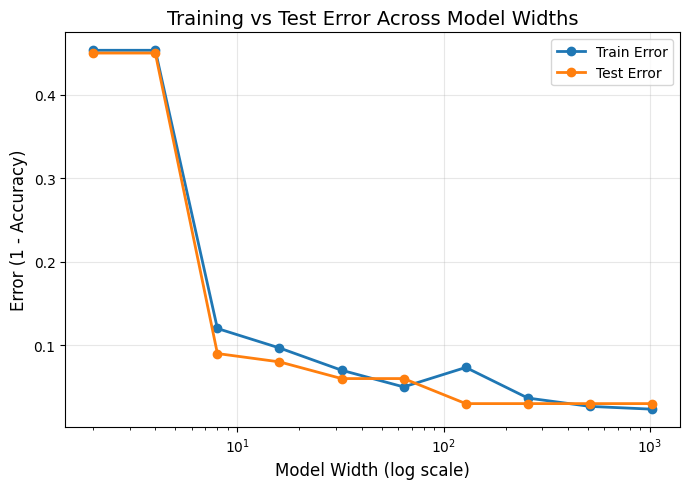

In [2]:
import matplotlib.pyplot as plt

# -----------------------------
# Training vs Test Error Curve
# -----------------------------
plt.figure(figsize=(7, 5))

plt.plot(widths, train_errors, "-o", label="Train Error", linewidth=2)
plt.plot(widths, test_errors, "-o", label="Test Error", linewidth=2)

plt.xscale("log")
plt.xlabel("Model Width (log scale)", fontsize=12)
plt.ylabel("Error (1 - Accuracy)", fontsize=12)
plt.title("Training vs Test Error Across Model Widths", fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("train_vs_test_error.png", dpi=150)
plt.show()


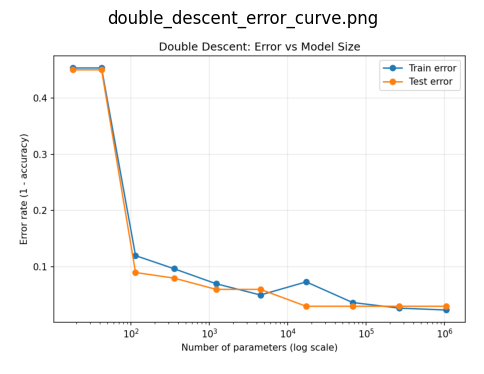

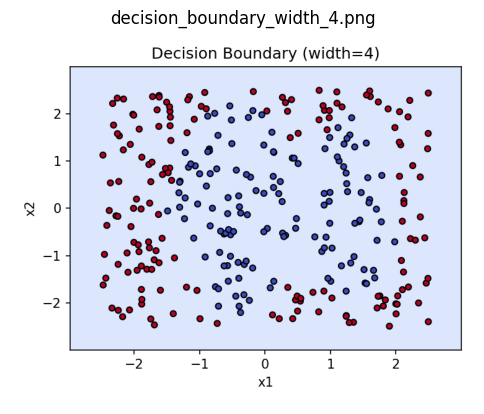

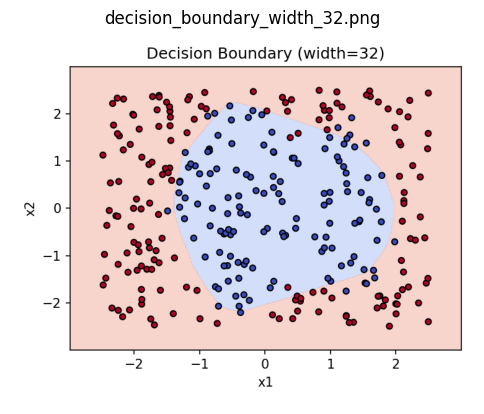

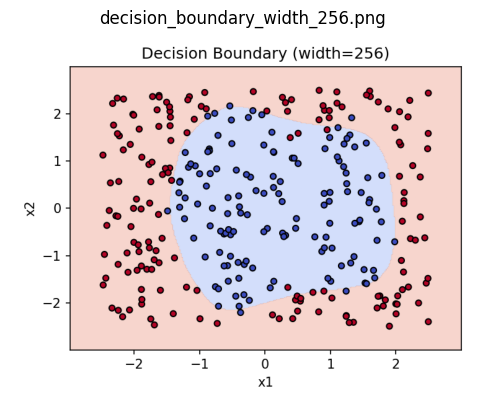

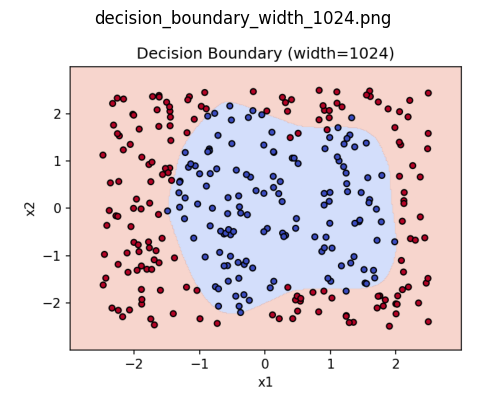

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

files = [
    "double_descent_error_curve.png",
    "decision_boundary_width_4.png",
    "decision_boundary_width_32.png",
    "decision_boundary_width_256.png",
    "decision_boundary_width_1024.png"
]

for file in files:
    try:
        img = mpimg.imread(file)
        plt.figure(figsize=(6, 5))
        plt.imshow(img)
        plt.axis('off')
        plt.title(file)
        plt.show()
    except FileNotFoundError:
        print(f"❌ File not found: {file}")


In [4]:
for w, acc in zip(widths, test_accs):
    print(f"Width {w}: Test Accuracy = {acc:.4f}")


NameError: name 'test_accs' is not defined

In [5]:
whos


Variable         Type        Data/Info
--------------------------------------
MLP              type        <class '__main__.MLP'>
X                Tensor      tensor([[-1.7466e+00, -2.<...>.2998e-01, -1.5640e+00]])
X_test           Tensor      tensor([[-6.3726e-01, -1.<...>.2998e-01, -1.5640e+00]])
X_test_cpu       Tensor      tensor([[-6.3726e-01, -1.<...>.2998e-01, -1.5640e+00]])
X_train          Tensor      tensor([[-1.7466e+00, -2.<...>.3299e+00,  2.2212e+00]])
X_train_cpu      Tensor      tensor([[-1.7466e+00, -2.<...>.3299e+00,  2.2212e+00]])
device           device      cuda
file             str         decision_boundary_width_1024.png
files            list        n=5
img              ndarray     600x750x4: 1800000 elems, type `float32`, 7200000 bytes (6.866455078125 Mb)
make_dataset     function    <function make_dataset at 0x7cfcbfcd76a0>
model            MLP         MLP(\n  (net): Sequential<...>res=2, bias=True)\n  )\n)
models           dict        n=10
mpimg            modu

In [6]:
print("Width\tTest Error")
for w, err in zip(widths, test_errors):
    print(f"{w}\t{err:.4f}")


Width	Test Error
2	0.4500
4	0.4500
8	0.0900
16	0.0800
32	0.0600
64	0.0600
128	0.0300
256	0.0300
512	0.0300
1024	0.0300
